In [10]:
import talk.config as con

% matplotlib inline

con.config_mosek()
con.config_configManager()
con.config_matplotlib()

Set MOSEKLM_LICENSE_FILE environment variable
Update ConfigManager


The Conditional Value at Risk
-------------------------------
https://en.wikipedia.org/wiki/Expected_shortfall

#### Thomas Schmelzer

The $\alpha=0.99$ tail of a loss distribution 
-----------------------------------------------
<img src="talk/tail.jpg" style="margin-left:auto; margin-right:auto; display:block">

* In this talk we assume losses are postive. Larger losses, more pain... We want negative losses!

* The value at risk $\mathtt{VaR}_{\alpha}$ at level $\alpha$ is (the smallest) loss such that $\alpha \%$ of losses are smaller than $\mathtt{VaR}_{\alpha}$.

* This does not say anything about the magnitude of the losses larger than the $\mathtt{VaR}_{\alpha}$. We can only make statements about their number: $n(1 - \alpha)$

* To describe the tail of the return distribution better one could use the Conditional Value at Risk $\mathtt{CVaR}_{\alpha}$, defined as the mean of the losses larger (or equal) than the $\mathtt{VaR}_{\alpha}$.


In [13]:
import numpy as np


def tail(ts, alpha=0.99):
    return np.sort(ts)[int(len(ts) * alpha):]


def value_at_risk(ts, alpha=0.99):
    return tail(ts, alpha)[0]


def cvalue_at_risk(ts, alpha=0.99):
    return np.mean(tail(ts, alpha))


R = np.array([-1.0, 2.0, 3.0, 2.0, 5.0, 2.0, 0.0, 1.0, -2.0, -2.0])
print("Length: {0}".format(len(R)))
print("Tail:   {0}".format(tail(R, alpha=0.80)))
print("VaR:    {0}".format(value_at_risk(R, alpha=0.80)))
print("CVaR:   {0}".format(cvalue_at_risk(R, alpha=0.80)))

Length: 10
Tail:   [ 3.  5.]
VaR:    3.0
CVaR:   4.0


Sub-additivity:
---------------

$\mathrm{If}\; Z_1,Z_2 \in \mathcal{L} ,$ then $\varrho(Z_1 + Z_2) \leq \varrho(Z_1) + \varrho(Z_2)$

The risk of two portfolios together cannot get any worse than adding the two risks separately: this is the diversification principle.

The $\mathtt{VaR}_{\alpha}$ **is not** sub-additive. It is not convex either.

The $\mathtt{CVaR}$ **is** sub-additive and convex. 


Other convex risk measures:    Entropic Value-at-Risk, ...


In [7]:
import numpy.random as nr
import pandas as pd

# number of draws...
n = 10000000
alpha = 0.99

# Let's define two portfolios A and B
frame = pd.DataFrame(data=nr.uniform(0, 10, size=(n, 2)) * nr.binomial(1, p=0.0075, size=(n, 2)), columns=["A", "B"])
frame["A+B"] = frame.sum(axis=1)

print("VALUE AT RISK")
print(frame.apply(value_at_risk, alpha=alpha))

print("CONDITIONAL VALUE AT RISK")
print(frame.apply(cvalue_at_risk, alpha=alpha))

VALUE AT RISK
A      0.000000
B      0.000000
A+B    3.327141
dtype: float64
CONDITIONAL VALUE AT RISK
A      3.766759
B      3.744397
A+B    6.684916
dtype: float64


We introduce a free variable $\gamma$ and define the function $f$ as:
\begin{eqnarray}
f(\gamma) &=& \gamma + \frac{1}{n\,(1-\alpha)}\sum (r_i - \gamma)^{+}
\end{eqnarray}
This is a continuous and convex function (in $\gamma$). The first derivative is:
$$
f^{'}(\gamma) = 1 - \frac{\#\left\{r_i \geq \gamma\right\}}{n\,(1-\alpha)}
$$

If $\gamma$ such that $\#\{r_i \geq \gamma\}=n\,(1-\alpha)$:
- $\gamma$ is a minimizer of $f$. 
- $f(\gamma) =\mathtt{CVaR}_\alpha(\mathbf{r})$.

In particular:

* $f(\mathtt{VaR}_\alpha(\mathbf{r})) = \mathtt{CVaR}_\alpha(\mathbf{r})$. 

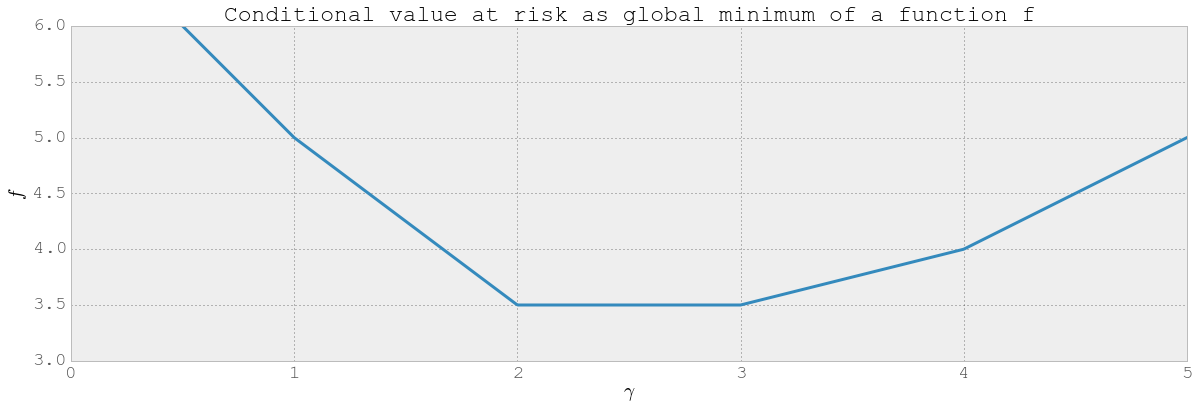

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def f(gamma, returns, alpha=0.99):
    excess = returns - gamma
    return gamma + 1.0 / (len(returns) * (1 - alpha)) * excess[excess > 0].sum()

r = np.array([-1.0, 2.0, 3.0, 2.0, 4.0, 2.0, 0.0, 1.0, -2.0, -2.0])
x = np.linspace(start=-1.0, stop=5.0, num=1000)
v = np.array([f(gamma=g, returns=r, alpha=0.80) for g in x])

plt.plot(x, v), plt.grid(True), plt.xlabel('$\gamma$'), plt.ylabel('$f$')
plt.title('Conditional value at risk as global minimum of a function f')
plt.axis([0, 5, 3, 6])
plt.show()

\begin{align}\mathtt{CVaR}(\mathbf{r})=\min_{\gamma \in \mathbb{R}, \mathbf{t} \in \mathbb{R}^n} \,&\, \gamma + \frac{1}{n\,(1-\alpha)}\sum t_i\\
\text{s.t. }&t_i \geq r_i - \gamma \\
            &\mathbf{t}\geq 0
\end{align}

In [15]:
from mosek.fusion import *
import numpy as np

R = [-1.0, 2.0, 3.0, 2.0, 4.0, 2.0, 0.0, 1.0, -2.0, -2.0]

n = len(R)
# We are interested in CVaR for alpha=0.80, e.g. what's the mean of the 20% of the biggest losses
alpha = 0.80

with Model('cvar') as model:
    # introduce the variable for the var
    gamma = model.variable("gamma", 1, Domain.unbounded())

    # Auxiliary variable
    t = model.variable("t", n, Domain.greaterThan(0.0))

    # t > r-gamma <===> t + gamma > r
    model.constraint(Expr.add(t, Variable.repeat(gamma, n)), Domain.greaterThan(R))

    # gamma + 1/[n*(1-alpha)] * \sum{t}
    cvar = Expr.add(gamma, Expr.mul(1.0 / (n * (1 - alpha)), Expr.sum(t)))

    # minimization of the conditional value at risk
    model.objective(ObjectiveSense.Minimize, cvar)
    model.solve()

    print("A minimizer of f (<= VaR):  {0}".format(gamma.level()[0]))
    print("Minimum of f (== CVaR):     {0}".format(gamma.level()[0] + 1.0 / (n * (1 - alpha)) * np.array(t.level()).sum()))

A minimizer of f (<= VaR):  3.00000000011
Minimum of f (== CVaR):     3.50000000007


Summary
-------

* The Conditional Value at Risk $\mathtt{CVaR}$ is a coherent risk measure.

* We could compute the $\mathtt{CVaR}$ for a vector of length $n$ by solving a convex program in $n+1$ dimensions.

* We do not need to sort the elements nor do we need to know the Value at Risk $\mathtt{VaR}$.

In practice the vector $\mathbf{r}$ is not given. Rather we have $m$ assets and try to find a linear combination of their corresponding return vectors such that the resulting portfolio has minimal Conditional Value at Risk.

Further Reading
----------------
* Cornuejols, Tutuncu, Optimization Methods in Finance, Chapter 17
* Publications by S. Uryasev


Minimizer of f (<= VaR):  0.108052116283
Minimum of f (== CVaR):   0.127106958317


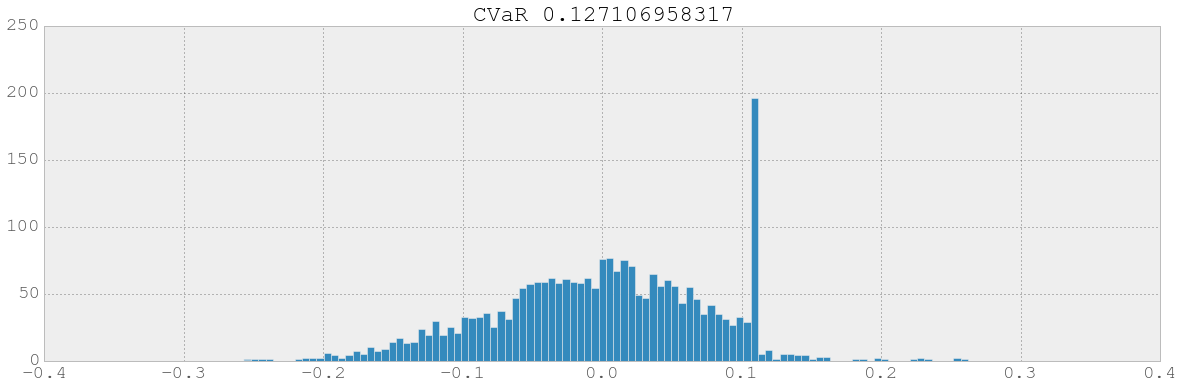

In [11]:
from mosek.fusion import *
import numpy as np
import matplotlib.pyplot as plt

R = np.random.randn(2500,200)

n,m = R.shape
n = int(n)
m = int(m)
# We are interested in CVaR for alpha=0.95, e.g. what's the mean of the 5% of the biggest losses
alpha = 0.95

with Model('cvar') as model:
    # introduce the variable for the var
    gamma = model.variable("gamma", 1, Domain.unbounded())
    weight = model.variable("weight",m, Domain.inRange(0.0, 1.0))
    # Auxiliary variable
    t = model.variable("t", n, Domain.greaterThan(0.0))

    # e'*w = 1
    model.constraint(Expr.sum(weight), Domain.equalsTo(1.0))
        
    # r = R*w
    r = Expr.mul(DenseMatrix(R), weight)
        
    # t > r-gamma <===> t + gamma - r > 0
    model.constraint(Expr.sub(Expr.add(t, Variable.repeat(gamma, n)),r), Domain.greaterThan(0.0))   

    # gamma + 1/[n*(1-alpha)] * \sum{t}
    cvar = Expr.add(gamma, Expr.mul(1.0 / (n * (1 - alpha)), Expr.sum(t)))

    # minimization of the conditional value at risk
    model.objective(ObjectiveSense.Minimize, cvar)
    model.solve()

    var = gamma.level()[0]
    cvar = gamma.level()[0] + 1.0 / (n * (1 - alpha)) * np.array(t.level()).sum()
    print("Minimizer of f (<= VaR):  {0}".format(var))
    print("Minimum of f (== CVaR):   {0}".format(cvar))
    a=np.dot(R,weight.level())
    plt.hist(a, bins=100)
    plt.axis([-0.4, 0.4, 0, 250])
    plt.title("CVaR {0}".format(cvar))
    plt.show()